In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import numpy as np

from meshes import *

from NumericalSolutions import *
from DynamicSolutions import *

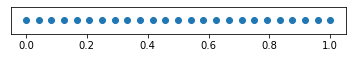

In [2]:
# Spatial resolution of mesh
N = 25

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);
elems = np.array(elems)[:,:]

In [3]:
E=1
I=1
mu = 1

In [4]:
M0 = 0
ML = 0
QL = 0
a0 = 0
aL = 0
a = 0
b = 0

q = 1

two_sided_support = True 

if two_sided_support:
    boundary_conditions = {'M0': M0, 'ML': ML, 'a0': a0, 'aL': aL}
else:
    boundary_conditions = {'QL': QL, 'ML': ML, 'a': a, 'b': b}

In [5]:
"""
DynamicCase = Dynamic(E=E, I=I, N=N, L=L, 
                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":0},
                      #parameters = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":4},
                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":5, "q":4},
                      two_sided_support=True)
"""
DynamicCase = DynamicSolutionBothEnds(E=E, I=I, N=N, L=L, h=0.05,
                                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":0},
                                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":0, "q":10}
                                     )
tsteps = 500

h = 0.001

DynamicCase.Newmark.h = h
DynamicCase.Newmark.run(tsteps)

(array([ 0.00000000e+00,  3.24033369e-01,  1.34558180e-02,  3.20781026e-01,
         2.66478527e-02,  3.11489727e-01,  3.93395206e-02,  2.96885439e-01,
         5.13239367e-02,  2.77636850e-01,  6.24175601e-02,  2.54180178e-01,
         7.24507573e-02,  2.26773912e-01,  8.12643045e-02,  1.95696289e-01,
         8.87132742e-02,  1.61338215e-01,  9.46684409e-02,  1.24052720e-01,
         9.90163893e-02,  8.42814705e-02,  1.01666031e-01,  4.26541415e-02,
         1.02556528e-01, -4.53639511e-13,  1.01666031e-01, -4.26541415e-02,
         9.90163893e-02, -8.42814705e-02,  9.46684409e-02, -1.24052720e-01,
         8.87132742e-02, -1.61338215e-01,  8.12643045e-02, -1.95696289e-01,
         7.24507573e-02, -2.26773912e-01,  6.24175601e-02, -2.54180178e-01,
         5.13239367e-02, -2.77636850e-01,  3.93395206e-02, -2.96885439e-01,
         2.66478527e-02, -3.11489727e-01,  1.34558180e-02, -3.20781026e-01,
         0.00000000e+00, -3.24033369e-01,  3.88139041e+00, -3.88139041e+00]),
 array([ 0

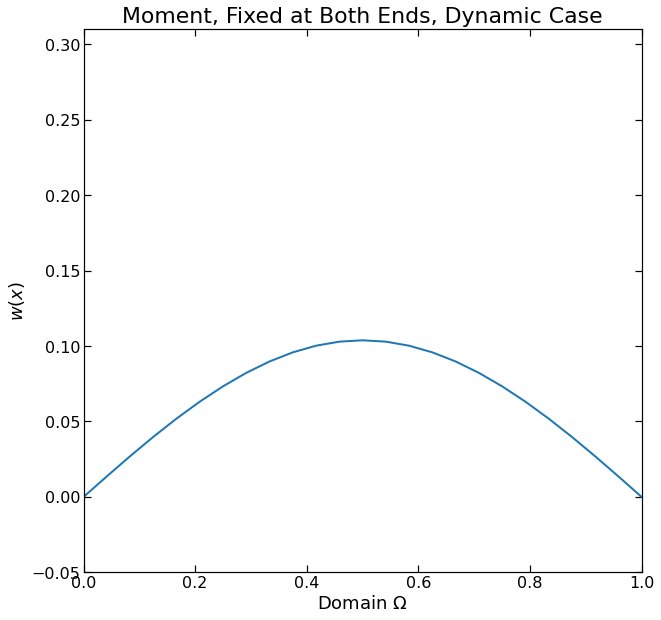

In [8]:
# get animations

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

plt.style.use("standard.mplstyle")

results = DynamicCase.Newmark.results
w = results["w"]

wmin = np.min(w)
wmax = np.max(w)

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(( 0, L))
ax.set_ylim((wmin - 0.05 , wmax + 0.05))
ax.set_ylabel(r"$w(x)$")
ax.set_xlabel(r"Domain $\Omega$")
plt.title('Moment, Fixed at Both Ends, Dynamic Case')
#try: ax.set_ylim((np.min(-u[nsteps-1][:-2][::2])-0.5, np.max(u[nsteps-1][:-2][::2])+0.5))
#except: ax.set_ylim((np.min(-solution), np.max(solution)))
        
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(nodes, w[i])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tsteps, interval=50, 
                               blit=True)
#HTML(anim.to_jshtml())
dpi = 200
writer = animation.writers['ffmpeg'](fps=20)
anim.save('./Report/dynamic_1.mp4',writer=writer,dpi=dpi)

plt.show()

In [ ]:
Max_Values = []

results = DynamicCase.Newmark.results
w = results["w"]
wp = results["wp"]
wd = results["wd"]

u = results["u"]
up = results["up"]
upp = results["upp"]

Me = DynamicCase.Newmark.Me
Se = DynamicCase.Newmark.Se
rhs = DynamicCase.dynamic_object.RHS_ext

In [ ]:
def Energy(u, up, M, S, Only_E1=False, Only_E2=False):
    
    up2 = up @ M
    
    wd2 = up2[:-2][::2]
    wd1 = up[:-2][::2]
    
    term1 = np.inner(wd2, wd1)
    
    u2 = u @ S
    w2 = u2[:-2][::2]
    w1 = u[:-2][::2]
    
    term2 = np.inner(w2, w1)

    if Only_E1:
        return term1
    
    elif Only_E2:
        return term2
    
    else:
        return term1 + term2
    
def ExternalEnergy(u, q):
    
    w = u[:-2][::2]
    q = q[:-2][::2]
    
    return 2*np.inner(w,q)

In [ ]:
E1 = []
E2 = []
E = []

Ext = []


for i in range(1,np.shape(w)[0]):
    
    up2 = up[i] @ Me
    
    wd2 = up2[:-2][::2]
    wd1 = up[i][:-2][::2]
    
    E1.append(np.inner(wd2, wd1))
    
    u2 = u[i] @ Se
    
    w2 = u2[:-2][::2]
    w1 = u[i][:-2][::2]
    
    E2.append(np.inner(w2, w1))
    
    E.append(np.inner(w2, w1) + np.inner(wd2, wd1))
    
    Ext.append(ExternalEnergy(u[i], rhs))
    
    

In [ ]:
E1 = []
E2 = []
E = []
Ext = []

for i in range(1,np.shape(w)[0]):
    
    
    E.append(Energy(u[i], up[i], Me, Se))
    E1.append(Energy(u[i], up[i], Me, Se, Only_E1=True))
    E2.append(Energy(u[i], up[i], Me, Se, Only_E2=True))
    Ext.append(ExternalEnergy(u[i], rhs))

In [ ]:
'''
plt.style.use("standard.mplstyle")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E, label="E")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E1, label="E1")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E2, label="E2")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), Ext, label="Ext")
plt.legend()
plt.title("Energy evolution using Newmark Method")
'''

In [ ]:
Energies = {}

hs = [0.01, 0.005, 0.001, 0.0005, 0.0001]


for h in hs:
    Energies[h] = []
    
for h in hs:
    
    tsteps = int(5 / h)
    
    DynamicCase = DynamicSolutionBothEnds(E=1, I=1, N=N, L=L, h=h,
                                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":1},
                                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":0, "q":2}
                                     )
    DynamicCase.Newmark.h = h
    DynamicCase.Newmark.run(tsteps)
    
    results = DynamicCase.Newmark.results
    u = results["u"]
    up = results["up"]

    Me = DynamicCase.Newmark.Me
    Se = DynamicCase.Newmark.Se
    
    for i in range(1,np.shape(u)[0]):

        Energies[h].append(Energy(u[i], up[i], Me, Se))

        

In [ ]:
hs = [0.01, 0.005, 0.001, 0.0005, 0.0001]
hs = [0.0001, 0.0005, 0.001]

for h in hs:
    
    plt.plot(h*np.array([i for i in range(int(5/h))]), Energies[h], label=h)
    
plt.legend()
plt.show()

In [ ]:
# get animations

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML


results = DynamicCase.Newmark.results
w = results["w"]

wmin = np.min(w)
wmax = np.max(w)

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(( 0, L))
ax.set_ylim((wmin - 0.05 , wmax + 0.05))
#try: ax.set_ylim((np.min(-u[nsteps-1][:-2][::2])-0.5, np.max(u[nsteps-1][:-2][::2])+0.5))
#except: ax.set_ylim((np.min(-solution), np.max(solution)))
        
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line.set_data(nodes, w[i])
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tsteps, interval=50, 
                               blit=True)
#HTML(anim.to_jshtml())
#dpi = 200
#writer = animation.writers['ffmpeg'](fps=20)
#anim.save('./Report/dynamic_2.mp4',writer=writer,dpi=dpi)
plt.show()

In [ ]:
1